## Microsoft Malware Prediction

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

### Import Data

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [57]:
%%time

# Change working directory
os.chdir('C:/Users/vfarfan/DS/Ms')
# Load the data
df = pd.read_csv("data/train.csv", dtype={
    'MachineIdentifier':'category', 'ProductName':'category', 'EngineVersion':'category', 'AppVersion':'category',
       'AvSigVersion':'category', 'IsBeta':'int8', 'RtpStateBitfield':'float16', 'IsSxsPassiveMode':'int8',
       'DefaultBrowsersIdentifier':'category', 'AVProductStatesIdentifier':'category',
       'AVProductsInstalled':'float16', 'AVProductsEnabled':'float16', 'HasTpm':'category',
       'CountryIdentifier':'category', 'CityIdentifier':'category', 'OrganizationIdentifier':'category',
       'GeoNameIdentifier':'category', 'LocaleEnglishNameIdentifier':'category', 'Platform':'category',
       'Processor':'category', 'OsVer':'category', 'OsBuild':'int16', 'OsSuite':'int16', 'OsPlatformSubRelease':'category',
       'OsBuildLab':'category', 'SkuEdition':'category', 'IsProtected':'float16', 'AutoSampleOptIn':'int8', 
        'PuaMode':'category',
       'SMode':'float16', 'IeVerIdentifier':'float16', 'SmartScreen':'category', 'Firewall':'float16', 
        'UacLuaenable':'float16',
       'Census_MDC2FormFactor':'category', 'Census_DeviceFamily':'category',
       'Census_OEMNameIdentifier':'category', 'Census_OEMModelIdentifier':'category',
       'Census_ProcessorCoreCount':'float16', 'Census_ProcessorManufacturerIdentifier':'category',
       'Census_ProcessorModelIdentifier':'category', 'Census_ProcessorClass':'category',
       'Census_PrimaryDiskTotalCapacity':'float32', 'Census_PrimaryDiskTypeName':'category',
       'Census_SystemVolumeTotalCapacity':'float32', 'Census_HasOpticalDiskDrive':'int16',
       'Census_TotalPhysicalRAM':'float16', 'Census_ChassisTypeName':'category',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches':'float16',
       'Census_InternalPrimaryDisplayResolutionHorizontal':'float16',
       'Census_InternalPrimaryDisplayResolutionVertical':'float16',
       'Census_PowerPlatformRoleName':'category', 'Census_InternalBatteryType':'category',
       'Census_InternalBatteryNmberOfCharges':'float16', 'Census_OSVersion':'category',
       'Census_OSArchitecture':'category', 'Census_OSBranch':'category', 'Census_OSBuildNumber':'int16',
       'Census_OSBuildRevision':'int16', 'Census_OSEdition':'category', 'Census_OSSkuName':'category',
       'Census_OSInstallTypeName':'category', 'Census_OSInstallLanguageIdentifier':'category',
       'Census_OSUILocaleIdentifier':'category', 'Census_OSWUAutoUpdateOptionsName':'category',
       'Census_IsPortableOperatingSystem':'int16', 'Census_GenuineStateName':'category',
       'Census_ActivationChannel':'category', 'Census_IsFlightingInternal':'float16',
       'Census_IsFlightsDisabled':'float16', 'Census_FlightRing':'category',
       'Census_ThresholdOptIn':'float16', 'Census_FirmwareManufacturerIdentifier':'category',
       'Census_FirmwareVersionIdentifier':'category', 'Census_IsSecureBootEnabled':'int16',
       'Census_IsWIMBootEnabled':'float16', 'Census_IsVirtualDevice':'float16',
       'Census_IsTouchEnabled':'int16', 'Census_IsPenCapable':'int16',
       'Census_IsAlwaysOnAlwaysConnectedCapable':'float16', 'Wdft_IsGamer':'float16',
       'Wdft_RegionIdentifier':'category', 'HasDetections':'int16'
}
#     , nrows=1000000, low_memory=False
)

Wall time: 5min 25s


In [3]:
# df['SMode'].head()
print(df.size)
print(df.dtypes)

740483089
MachineIdentifier                          category
ProductName                                category
EngineVersion                              category
AppVersion                                 category
AvSigVersion                               category
IsBeta                                         int8
RtpStateBitfield                            float16
IsSxsPassiveMode                               int8
DefaultBrowsersIdentifier                  category
AVProductStatesIdentifier                  category
AVProductsInstalled                         float16
AVProductsEnabled                           float16
HasTpm                                     category
CountryIdentifier                          category
CityIdentifier                             category
OrganizationIdentifier                     category
GeoNameIdentifier                          category
LocaleEnglishNameIdentifier                category
Platform                                   category
Pr

In [5]:
df = df.set_index('MachineIdentifier')
print('Dimensiones: ',df.shape)
df.head()

Dimensiones:  (8921483, 82)


,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447,1.0,...,36144,0,NaN,0.0,0,0,0.0,0.0,10,0
000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447,1.0,...,57858,0,NaN,0.0,0,0,0.0,0.0,8,0
000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447,1.0,...,52682,0,NaN,0.0,0,0,0.0,0.0,3,0
00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447,1.0,...,20050,0,NaN,0.0,0,0,0.0,0.0,3,1
000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447,1.0,...,19844,0,0.0,0.0,0,0,0.0,0.0,1,1


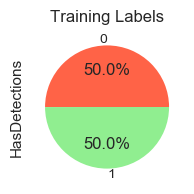

In [6]:
# df['OrganizationIdentifier'].value_counts()
colors = ['tomato','lightgreen']
df['HasDetections'].value_counts().plot.pie(figsize=(2,2), autopct='%1.1f%%', colors=colors)
plt.title('Training Labels')
plt.show()

#### Eliminar columnas con valores constantes
Elimino columnas con valores constantes o con sólo dos valores pero uno de ellos con muy poca frecuencia

In [20]:
# df = df.drop('IsBeta', axis=1)
# df = df.drop('AutoSampleOptIn', axis=1)
# df = df.drop('PuaMode', axis=1)
# df = df.drop('Census_IsFlightingInternal', axis=1)
# df = df.drop('Census_IsFlightsDisabled', axis=1)
# df = df.drop('Census_IsWIMBootEnabled', axis=1)

## Pre Processing

In [7]:
from sklearn import preprocessing

In [18]:
dfproc = pd.DataFrame(df['HasDetections'], columns=['HasDetections'], index=df.index)
print(dfproc.shape)
dfproc.head()

(8921483, 1)


,HasDetections
MachineIdentifier,
0000028988387b115f69f31a3bf04f09,0
000007535c3f730efa9ea0b7ef1bd645,0
000007905a28d863f6d0d597892cd692,0
00000b11598a75ea8ba1beea8459149f,1
000014a5f00daa18e76b81417eeb99fc,1


#### Product Name

In [19]:
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(df['ProductName'])
# View the labels
list(le.classes_)
# Apply the fitted encoder to the pandas column
dfproc['ProductName'] = le.transform(df['ProductName']) 

In [20]:
dfproc.head()

,HasDetections,ProductName
MachineIdentifier,,
0000028988387b115f69f31a3bf04f09,0,4
000007535c3f730efa9ea0b7ef1bd645,0,4
000007905a28d863f6d0d597892cd692,0,4
00000b11598a75ea8ba1beea8459149f,1,4
000014a5f00daa18e76b81417eeb99fc,1,4


#### EngineVersion

Categories:  7


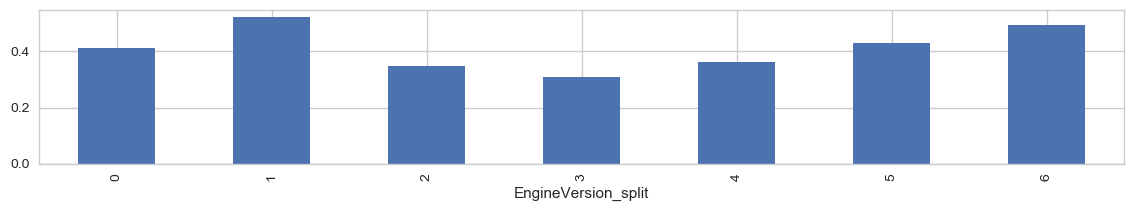

In [21]:
dfproc['EngineVersion_split'] = df['EngineVersion'].str.split('.').str.get(3)
print('Categories: ', dfproc['EngineVersion_split'].nunique())

#### AppVersion_split

In [24]:
dfproc['AppVersion_split'] = df['AppVersion'].str.split('.').str.get(1)
print('Categories: ', dfproc['AppVersion_split'].nunique())
dfproc['AppVersion_split2'] = df['AppVersion'].str.split('.').str.get(2)
print('Categories: ', dfproc['AppVersion_split2'].nunique())

Categories:  15
Categories:  39


#### AvSigVersion

In [25]:
dfproc['AvSigVersion_split'] = df['AvSigVersion'].str.split('.').str.get(1)
print('Categories: ', dfproc['AvSigVersion_split'].nunique())

Categories:  51


In [26]:
dfproc['AvSigVersion_split2'] = df['AvSigVersion'].str.split('.').str.get(2)

#### RtpStateBitfield

In [27]:
dfproc['RtpStateBitfield'] = df['RtpStateBitfield']

#### IsSxsPassiveMode

In [28]:
dfproc['IsSxsPassiveMode'] = df['IsSxsPassiveMode']

#### DefaultBrowsersIdentifier

In [29]:
dfproc['DefaultBrowsersIdentifier'] = df['DefaultBrowsersIdentifier']

#### AVProductStatesIdentifier

In [50]:
dfproc['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier']
y1 = pd.DataFrame(dfproc['AVProductStatesIdentifier'].value_counts().nlargest(20))
dfproc['AVProductStatesIdentifier'] = pd.Series(np.where(dfproc['AVProductStatesIdentifier'].isin(y1.index),dfproc['AVProductStatesIdentifier'],'other'))
dfproc['AVProductStatesIdentifier'].value_counts()


Series([], Name: AVProductStatesIdentifier, dtype: int64)

In [53]:
# df['AVProductStatesIdentifier'].value_counts().nlargest(20)
dfproc['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier']
y1 = pd.DataFrame(dfproc['AVProductStatesIdentifier'].value_counts().nlargest(20))
print(sum(dfproc['AVProductStatesIdentifier'].isin(y1.index)))
pd.Series(np.where(dfproc['AVProductStatesIdentifier'].isin(y1.index),dfproc['AVProductStatesIdentifier'],'other')).value_counts()

7809124


53447    5824565
other    1112359
7945      475897
47238     327656
62773     266764
46413     112878
23657     100455
49480      99899
41571      97659
29199      73550
51954      67616
22728      45221
46669      44855
43856      44354
43927      43790
3371       40700
6630       35198
40431      29087
68585      28706
61343      26848
63682      23426
dtype: int64

In [49]:
y1

,AVProductStatesIdentifier
53447,5824565
7945,475897
47238,327656
62773,266764
46413,112878
23657,100455
49480,99899
41571,97659
29199,73550
51954,67616


#### AVProductsEnabled

In [ ]:
dfproc['AVProductsEnabled'] = df['AVProductsEnabled']

In [21]:
df = df.loc[df['AvSigVersion'].str.split('.').str.get(1).str.isdigit(),:]
# df.loc['9686a9afcb31e21607609c18f6d66c49', :]
df.shape
# df = df.drop(['9686a9afcb31e21607609c18f6d66c49'])

(8921482, 76)

In [22]:
df['AppVersion_split'] = df['AppVersion'].str.split('.').str.get(1).astype(int)
df['AvSigVersion_split'] = df['AvSigVersion'].str.split('.').str.get(1).astype(int)
df['EngineVersion_split'] = df['EngineVersion'].str.split('.').str.get(2).astype(int)

## Feature Selection

In [54]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

In [34]:
training_features = ['ProductName'
                     , 'AppVersion_split'
                     , 'RtpStateBitfield'
                     , 'IsSxsPassiveMode'
                     , 'Firewall'
#                      ,'AvSigVersion_split'#,'EngineVersion_split'
                    ]

In [55]:
X = df[true_numerical_columns]
X.head()

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
MachineIdentifier,,,,,,,,
0000028988387b115f69f31a3bf04f09,4.0,inf,inf,4096.0,18.906250,1440.0,900.0,4.294967e+09
000007535c3f730efa9ea0b7ef1bd645,4.0,inf,inf,4096.0,13.898438,1366.0,768.0,1.000000e+00
000007905a28d863f6d0d597892cd692,4.0,inf,inf,4096.0,21.500000,1920.0,1080.0,4.294967e+09
00000b11598a75ea8ba1beea8459149f,4.0,inf,inf,4096.0,18.500000,1366.0,768.0,4.294967e+09
000014a5f00daa18e76b81417eeb99fc,4.0,inf,inf,6144.0,14.000000,1366.0,768.0,0.000000e+00


### Train/Validation Sets

In [56]:
from sklearn.model_selection import train_test_split

X = X
y = df.loc[:,'HasDetections']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_val.shape)
X_train.head()

(6691112, 8)
(2230371, 8)


,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
MachineIdentifier,,,,,,,,
ff2ebadb08cbdaf765c652941ceffa3f,2.0,inf,inf,2048.0,14.000000,1366.0,768.0,0.0
e419d39a86d609e7da24ba5b18a519e1,2.0,2.982400e+04,2.856000e+04,4096.0,11.601562,1366.0,768.0,0.0
eebd5b11bddeaa69c950a87df59ae653,4.0,inf,inf,4096.0,13.203125,1366.0,768.0,0.0
bd3d44bab0c5d123a8de421890bfda85,2.0,inf,inf,4096.0,15.500000,1280.0,768.0,0.0
29dac6fbb4b9ef8314667712b1595330,2.0,inf,inf,4096.0,17.296875,1600.0,900.0,0.0


### Mean Encoding

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

enc_features = ['ProductName']

In [38]:
%%time

# Expanding mean encoding
# train_new = last_tx
# features={'event'}
X_train_mean_enc = X_train
X_train_mean_enc['HasDetections'] = y_train
prior = X_train_mean_enc['HasDetections'].mean()

for col in enc_features:
    cumsum = X_train_mean_enc.groupby(col)['HasDetections'].cumsum() - X_train_mean_enc['HasDetections']
    cumcnt = X_train_mean_enc.groupby(col).cumcount()
    X_train_mean_enc[col + '_mean_exp'] = cumsum/cumcnt
    X_train_mean_enc[col + '_mean_exp'] = X_train_mean_enc[col + '_mean_exp'].replace(np.inf, np.nan)
    X_train_mean_enc[col + '_mean_exp'].fillna(prior, inplace=True)
    
    
    # Print correlation
#     encoded_feature = X_train_mean_enc[col + '_mean_exp'].values
#     print(encoded_feature)
#     print(col, np.corrcoef(X_train_mean_enc['label'].values, encoded_feature)[0][1])

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Wall time: 8.3 s


#### Apply mean encoding to validation set

In [39]:
X_val_mean_enc = X_val
# prior = train_new['HasDetections'].mean()

for feat in enc_features:
    means = X_val[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_exp'].mean())
    X_val_mean_enc[feat + '_mean_exp'] = means
    X_val_mean_enc[feat + '_mean_exp'].fillna(prior, inplace=True)


C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [40]:
X_train_mean_enc = X_train_mean_enc.drop('HasDetections', axis=1)
X_train = X_train_mean_enc.drop('ProductName', axis=1).fillna(0)
X_val = X_val_mean_enc.drop('ProductName', axis=1).fillna(0)

X_val_mean_enc.head()

,ProductName,AppVersion_split,RtpStateBitfield,IsSxsPassiveMode,Firewall,ProductName_mean_exp
MachineIdentifier,,,,,,
c74bc08707dcfa1af2d1af4867efe429,win8defender,18,7.0,0,1.0,0.500215
a81e37926fb7462e9aa5fe8f9c846029,win8defender,13,7.0,0,1.0,0.500215
635450c255e4f0d022dae3db676374be,win8defender,10,7.0,0,1.0,0.500215
cb990e4cfd8b7280c11d59eed743056d,mse,10,7.0,0,NaN,0.484140
d64e35204a0048ebfcf2efe37397a91f,win8defender,18,7.0,0,1.0,0.500215


### Funciones para evaluación de modelos

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def predict_eval(model, X_test, y):    
    pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:,1]
    
    # Evaluamos el modelo
    roc_auc = roc_auc_score(y, pred)
    logit_roc_auc = roc_auc_score(y, pred_prob)
    
    print('ROC_AUC: ', roc_auc)
    print('LOGIT_ROC_AUC: ', logit_roc_auc)

    # Making the Confusion Matrix
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y, pred)
    sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")

    # Plot the ROC AUC
    fpr, tpr, thresholds = roc_curve(y, pred_prob, pos_label=1)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label='AUC (area = %0.5f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.tight_layout()
    plt.show()
   
    return logit_roc_auc

from sklearn.model_selection import cross_val_score

def train_model(model, X_train, y_train, feat=False):
    #Fit the algorithm on the data
    model.fit(X_train, y_train)
        
    #Predict training set
    train_pred = model.predict(X_train)
    train_predp = model.predict_proba(X_train)[:,1]
    
    # CV
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score)
                                                                          ,np.min(cv_score),np.max(cv_score)))
    
    if feat:
        # Feature importance
        feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10,2))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')  

## 0. Sample submission

In [ ]:
y_pred = np.zeros(len(y_val))
y_predp = y_pred + 0.5

# Evaluamos el modelo
roc_auc = roc_auc_score(y_val, y_pred)
logit_roc_auc = roc_auc_score(y_val, y_predp)

print('ROC_AUC: ', roc_auc)
print('LOGIT_ROC_AUC: ', logit_roc_auc)

# Making the Confusion Matrix
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")

fpr, tpr, thresholds = roc_curve(y_val, y_predp, pos_label=1)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='AUC (area = %0.5f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.tight_layout()
plt.show()

## 1. Logistic Regression

In [42]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)

C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int8, int32, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, int32, float16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\vfarfan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int8, int32, float16, float64 were all converted to float64 by StandardScaler.
  """


CV Score : Mean - 0.5352105 | Std - 0.001129873 | Min - 0.5337697 | Max - 0.5364159
ROC_AUC:  0.52911562745
LOGIT_ROC_AUC:  0.535359566638


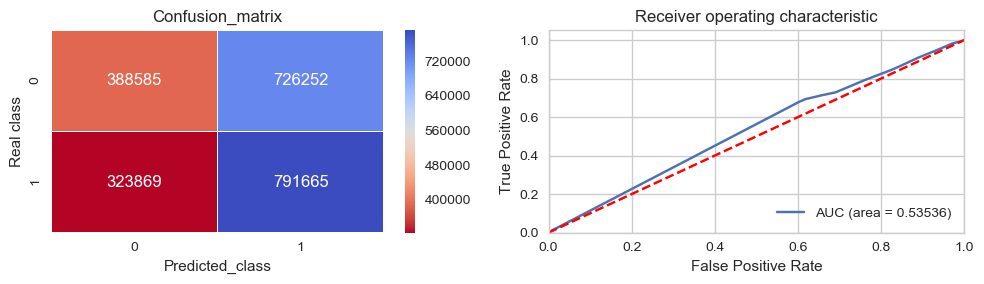

Wall time: 1min 21s


In [43]:
%%time

from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(solver='lbfgs')
train_model(lr_classifier, X_train_sc, y_train)

# Predict
predict_eval(lr_classifier, X_val_sc, y_val)

In [44]:
X_train_sc = 0
X_val_sc = 0

## 2. XGBoost

CV Score : Mean - 0.5481387 | Std - 0.0006522541 | Min - 0.5473602 | Max - 0.5493051
ROC_AUC:  0.53948309684
LOGIT_ROC_AUC:  0.547624313287


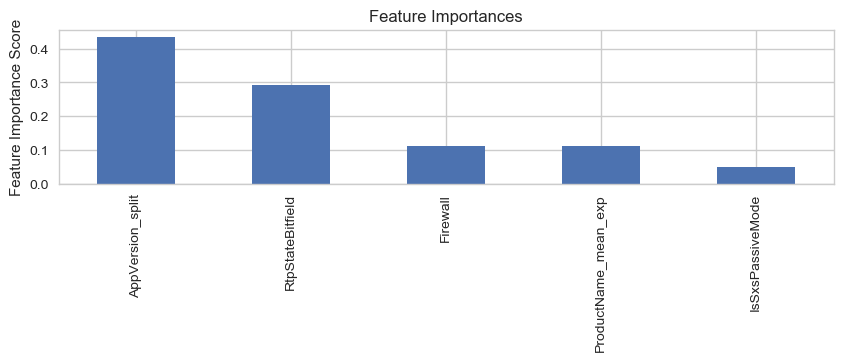

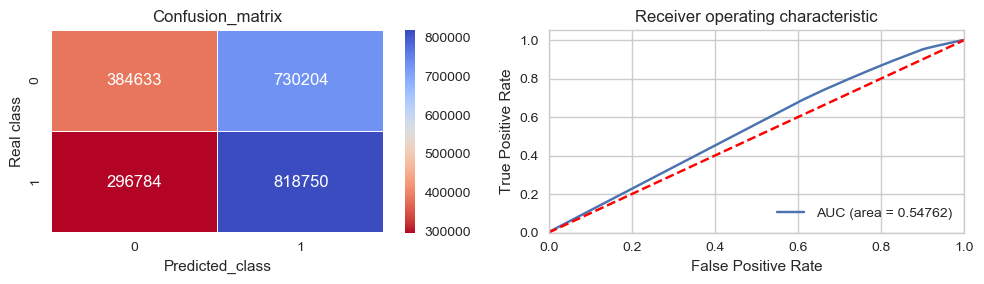

Wall time: 18min 35s


In [45]:
%%time

from xgboost import XGBClassifier

XGB_classifier = XGBClassifier()
train_model(XGB_classifier, X_train, y_train, feat=True)

# Predict
predict_eval(XGB_classifier, X_val, y_val)

In [ ]:
df=0

In [ ]:
# X_train=0
# y_train=0
# X_val=0
# y_val=0

# Prediction on Kaggle Test Set

In [ ]:
%%time

# Load the data
dftest = pd.read_csv("data/test.csv", dtype={
    'MachineIdentifier':'category', 'ProductName':'category', 'EngineVersion':'category', 'AppVersion':'category',
       'AvSigVersion':'category', 'IsBeta':'int8', 'RtpStateBitfield':'float16', 'IsSxsPassiveMode':'int8',
       'DefaultBrowsersIdentifier':'category', 'AVProductStatesIdentifier':'category',
       'AVProductsInstalled':'float16', 'AVProductsEnabled':'float16', 'HasTpm':'category',
       'CountryIdentifier':'category', 'CityIdentifier':'category', 'OrganizationIdentifier':'category',
       'GeoNameIdentifier':'category', 'LocaleEnglishNameIdentifier':'category', 'Platform':'category',
       'Processor':'category', 'OsVer':'category', 'OsBuild':'int16', 'OsSuite':'int16', 'OsPlatformSubRelease':'category',
       'OsBuildLab':'category', 'SkuEdition':'category', 'IsProtected':'float16', 'AutoSampleOptIn':'int8', 
        'PuaMode':'category',
       'SMode':'float16', 'IeVerIdentifier':'float16', 'SmartScreen':'category', 'Firewall':'float16', 
        'UacLuaenable':'float16',
       'Census_MDC2FormFactor':'category', 'Census_DeviceFamily':'category',
       'Census_OEMNameIdentifier':'category', 'Census_OEMModelIdentifier':'category',
       'Census_ProcessorCoreCount':'float16', 'Census_ProcessorManufacturerIdentifier':'category',
       'Census_ProcessorModelIdentifier':'category', 'Census_ProcessorClass':'category',
       'Census_PrimaryDiskTotalCapacity':'float16', 'Census_PrimaryDiskTypeName':'category',
       'Census_SystemVolumeTotalCapacity':'float16', 'Census_HasOpticalDiskDrive':'int16',
       'Census_TotalPhysicalRAM':'float16', 'Census_ChassisTypeName':'category',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches':'float16',
       'Census_InternalPrimaryDisplayResolutionHorizontal':'float16',
       'Census_InternalPrimaryDisplayResolutionVertical':'float16',
       'Census_PowerPlatformRoleName':'category', 'Census_InternalBatteryType':'category',
       'Census_InternalBatteryNmberOfCharges':'float16', 'Census_OSVersion':'category',
       'Census_OSArchitecture':'category', 'Census_OSBranch':'category', 'Census_OSBuildNumber':'int16',
       'Census_OSBuildRevision':'int16', 'Census_OSEdition':'category', 'Census_OSSkuName':'category',
       'Census_OSInstallTypeName':'category', 'Census_OSInstallLanguageIdentifier':'category',
       'Census_OSUILocaleIdentifier':'category', 'Census_OSWUAutoUpdateOptionsName':'category',
       'Census_IsPortableOperatingSystem':'int16', 'Census_GenuineStateName':'category',
       'Census_ActivationChannel':'category', 'Census_IsFlightingInternal':'float16',
       'Census_IsFlightsDisabled':'float16', 'Census_FlightRing':'category',
       'Census_ThresholdOptIn':'float16', 'Census_FirmwareManufacturerIdentifier':'category',
       'Census_FirmwareVersionIdentifier':'category', 'Census_IsSecureBootEnabled':'int16',
       'Census_IsWIMBootEnabled':'float16', 'Census_IsVirtualDevice':'float16',
       'Census_IsTouchEnabled':'int16', 'Census_IsPenCapable':'int16',
       'Census_IsAlwaysOnAlwaysConnectedCapable':'float16', 'Wdft_IsGamer':'float16',
       'Wdft_RegionIdentifier':'category', 'HasDetections':'int16'
}
#     , nrows=1000000, low_memory=False
)

In [ ]:
dftest['ProductName'] = pd.Categorical(dftest['ProductName'])
dftest['IsSxsPassiveMode'] = dftest['IsSxsPassiveMode'].astype(int)

In [ ]:
dftest = dftest.set_index('MachineIdentifier')
dftest.shape

### Pre processing

In [ ]:
dftest['AppVersion_split'] = dftest['AppVersion'].str.split('.').str.get(1).astype(int)
dftest['AvSigVersion_split'] = dftest['AvSigVersion'].str.split('.').str.get(1).astype(int)
dftest['EngineVersion_split'] = dftest['EngineVersion'].str.split('.').str.get(2).astype(int)


### Feature Selection

In [ ]:
test = dftest[training_features]
test.head()

### Feature encoding

In [ ]:
test_enc = test
for feat in enc_features:
    means = test[feat].map(X_train_mean_enc.groupby(feat)[feat + '_mean_exp'].mean())
    test_enc[feat + '_mean_exp'] = means
    test_enc[feat + '_mean_exp'].fillna(prior, inplace=True)

In [ ]:
test_enc.dtypes

In [ ]:
test_enc = test_enc.drop('ProductName', axis=1).fillna(0)
test_enc.head()

## XGBoost

In [ ]:
%%time

# Predicción de los labels 0 o 1
predictions = XGB_classifier.predict(test_enc)
dfsub = pd.DataFrame(predictions, columns=['HasDetections'], index=test_enc.index)
print(dfsub.shape)

sns.countplot('HasDetections',data=dfsub, palette=colors)
plt.show()

print(dfsub['HasDetections'].value_counts())

# Predicción de la probabilidad de conversión
predictions = XGB_classifier.predict_proba(test_enc)
dfsub = pd.DataFrame(predictions[:,1], columns=['HasDetections'], index=test_enc.index)

predictions[:,1]

In [ ]:
dfsub.head()
dfsub.shape

In [ ]:
%%time

dfsub.to_csv('20181217_XGB_exp.csv', sep=',', header=True)